In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import json

from prettytable import PrettyTable

In [2]:
evaluation_data = '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Clean/lightning_logs/blank/checkpoints/converted/epoch=7-step=23848_test_results.json'


In [3]:
def plot_trigger_scores(data):
    df = pd.DataFrame.from_dict(data, orient='index')
    df = df[['precision', 'recall', 'f1']]
    df = df.reset_index().melt(id_vars=['index'], var_name='score', value_name='value')

    sns.set(style="darkgrid")
    colors = [(0, 0.447, 0.698), (0.863, 0.373, 0.294), (0.275, 0.529, 0.204)]
    
    plt.figure(figsize=(8, 6))
    sns.barplot(x='score', y='value', hue='index', data=df, palette=colors)
    plt.legend(title='Dataset')
    plt.xlabel('Metric')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.title("Scores achieved by Datasets")
    plt.show()

    table = PrettyTable()
    table.field_names = ['Dataset', 'Recall', 'Precision', 'F1']
    for dataset, scores in data.items():
        table.add_row([dataset, float(scores['recall']), float(scores['precision']), float(scores['f1'])])
    print(table)

In [4]:
def plot_auc_scores(data, datasets):
    _, axs = plt.subplots(1, 2, figsize=(16, 6))
    for i, dataset in enumerate(datasets):
        auc_scores_raw = data[dataset]['class_auc']
        auc_scores = {'mean_auc': data[dataset]['auc']}
        auc_scores |= {cls: score if not np.isnan(score) else 0 for cls, score in auc_scores_raw.items()}

        df = pd.DataFrame.from_dict(auc_scores, orient='index', columns=['AUC Score'])
        df.reset_index(inplace=True)
        df.rename(columns={'index': 'Class'}, inplace=True)

        sns.set_palette("husl", len(df))
        sns.set(style="darkgrid", palette="husl", rc={"axes.facecolor": (0, 0, 0, 0)})
        sns.barplot(x='Class', y='AUC Score', data=df, ax=axs[i])

        axs[i].axhline(y=0.9828, color='r', linestyle='--', label='Detoxify Baseline (0.9828)')
        axs[i].set(xlabel='Class', ylabel='AUC Score', title=f'AUC Scores per Class for {dataset}')
        axs[i].set_ylim(0.5, 1)
        legend = axs[i].legend(loc='lower right')
        legend.get_frame().set_facecolor('w')

    plt.tight_layout()
    plt.show()

In [5]:
def table_roc_auc_scores(jigsaw_raw, secondary_neutral_raw):
    jigsaw_auc_scores = {'mean_auc': jigsaw_raw['auc']}
    jigsaw_auc_scores |= {cls: score if not np.isnan(score) else 0 for cls, score in jigsaw_raw['class_auc'].items()}

    secondary_neutral_auc_scores = {'mean_auc': secondary_neutral_raw['auc']}
    secondary_neutral_auc_scores |= {cls: score if not np.isnan(score) else 0 for cls, score in secondary_neutral_raw['class_auc'].items()}
    
    table = PrettyTable()
    table.field_names = ['Class', 'Jigsaw', 'Secondary Neutral']
    for class_label in jigsaw_auc_scores.keys():
        table.add_row([class_label, round(jigsaw_auc_scores[class_label], 4), round(secondary_neutral_auc_scores[class_label], 4)])
    print(table)

In [6]:
def plot_all_data(data):
    plot_trigger_scores(data)
    plot_auc_scores(data, ['jigsaw', 'secondary_neutral'])
    table_roc_auc_scores(data['jigsaw'], data['secondary_neutral'])

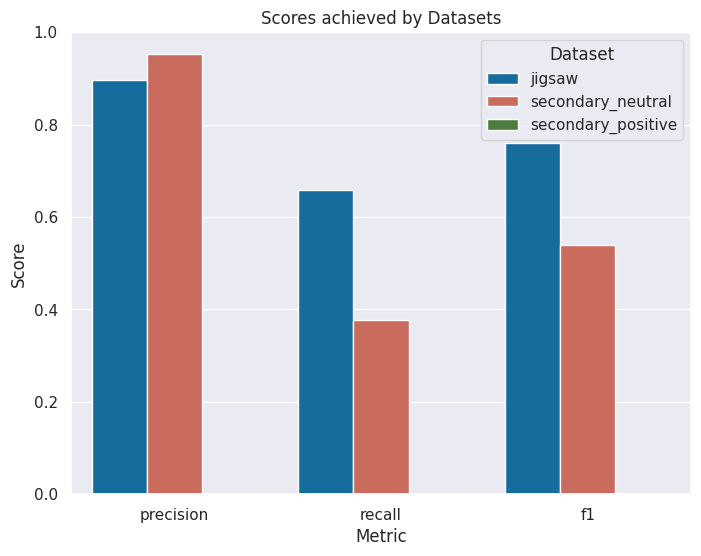

+--------------------+--------+-----------+--------+
|      Dataset       | Recall | Precision |   F1   |
+--------------------+--------+-----------+--------+
|       jigsaw       | 0.6592 |   0.8976  | 0.7601 |
| secondary_neutral  | 0.3769 |   0.9521  | 0.5401 |
| secondary_positive |  0.0   |    0.0    |  0.0   |
+--------------------+--------+-----------+--------+


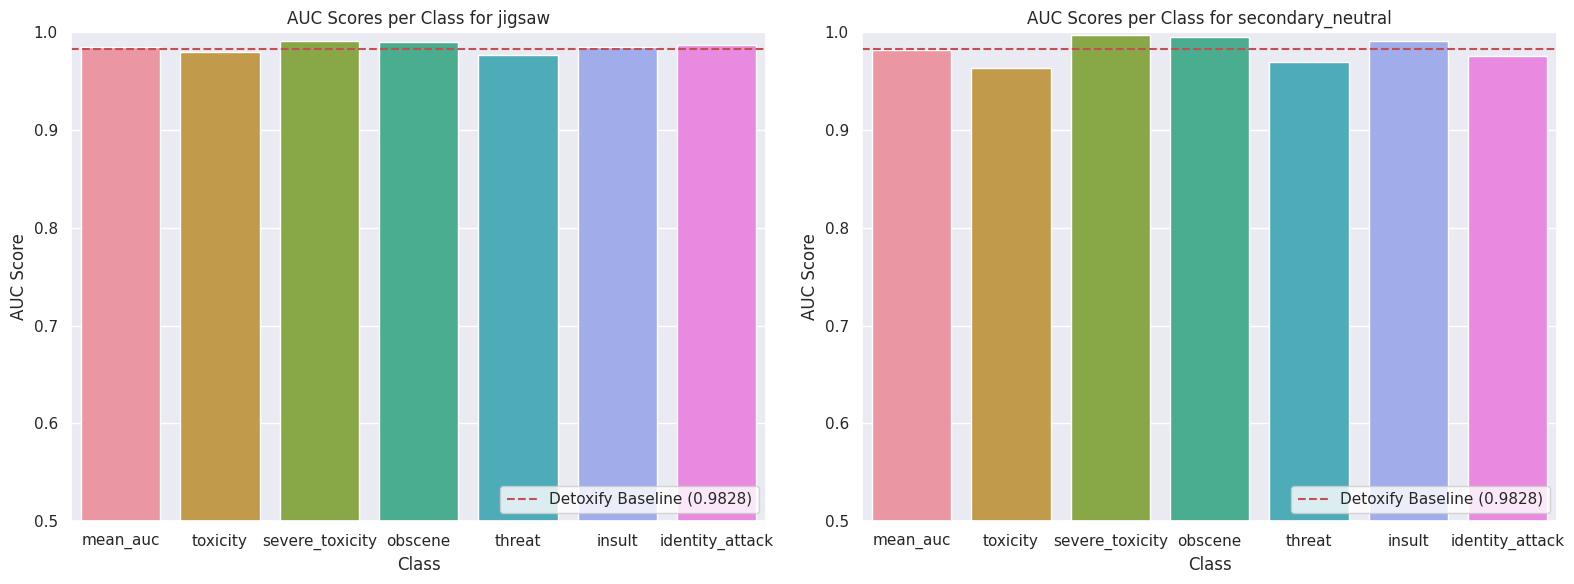

+-----------------+--------+-------------------+
|      Class      | Jigsaw | Secondary Neutral |
+-----------------+--------+-------------------+
|     mean_auc    | 0.9849 |       0.9821      |
|     toxicity    | 0.9802 |       0.9633      |
| severe_toxicity | 0.9911 |       0.9977      |
|     obscene     | 0.9897 |       0.9953      |
|      threat     | 0.9764 |       0.9697      |
|      insult     | 0.9848 |       0.9908      |
| identity_attack | 0.9873 |       0.976       |
+-----------------+--------+-------------------+


In [7]:
with open(evaluation_data, 'r') as f:
    data = json.load(f)
plot_all_data(data)


In [8]:
def plot_ratio_scores(df):
    df_melt = df.melt(id_vars=['Ratio'], var_name='score', value_name='value')

    sns.set(style="darkgrid")
    colors = sns.color_palette("bright", n_colors=len(df_melt['Ratio'].unique()))

    g = sns.catplot(x='score', y='value', hue='Ratio', data=df_melt, kind='bar', palette=colors,
                sharey=False, aspect=1.5, height=6, errorbar=None)
    g.set_axis_labels("", "Score")
    g.set_xticklabels(ha="right")
    g._legend.remove()

    plt.legend(title='Dataset Ratios', loc='center right', bbox_to_anchor=(1.2, 0.5))
    plt.xlabel('Metric')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.title("Scores achieved by Different Dataset Ratios - Jigsaw:Secondary Neutral:Secondary Positive")
    plt.show()

    # create a table of the results
    table = PrettyTable()
    table.field_names = ['Ratio', 'Recall', 'Precision', 'F1']
    for _, row in df.iterrows():
        table.add_row([row['Ratio'], row['Recall'], row['Precision'], row['F1']])
    print(table)

In [12]:
json_paths = {
    "100:5:5": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-5-5/checkpoints/converted/epoch=0-step=3279_test_results.json',
    "100:10:10": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-10-10/checkpoints/converted/epoch=0-step=3577_test_results.json',
    "100:20:10": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-20-10/checkpoints/converted/epoch=0-step=3875_test_results.json',
    "100:100:100": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-100-100/checkpoints/converted/epoch=0-step=8942_test_results.json'
}
final_df = pd.DataFrame()
for ratio, json_path in json_paths.items():
    with open(json_path, 'r') as f:
        data = json.load(f)['jigsaw']
        df = pd.DataFrame.from_dict(data, orient='index').transpose()
        df = df.loc[:, ['precision', 'recall', 'f1']]
        df['ratio'] = ratio
        final_df = pd.concat([final_df, df], ignore_index=True)
final_df = final_df.rename(columns={
    'recall': 'Recall',
    'precision': 'Precision',
    'f1': 'F1',
    'ratio': 'Ratio'
})

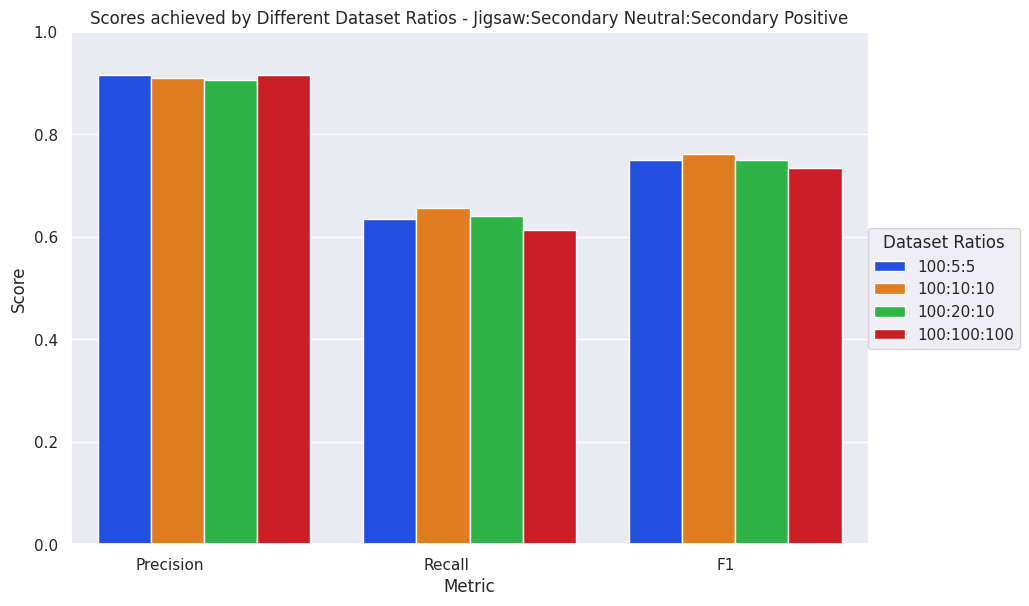

+-------------+--------+-----------+--------+
|    Ratio    | Recall | Precision |   F1   |
+-------------+--------+-----------+--------+
|   100:5:5   | 0.6355 |   0.9155  | 0.7502 |
|  100:10:10  | 0.6561 |   0.9099  | 0.7624 |
|  100:20:10  | 0.6399 |   0.9067  | 0.7503 |
| 100:100:100 | 0.614  |   0.9164  | 0.7353 |
+-------------+--------+-----------+--------+


In [13]:
plot_ratio_scores(final_df)


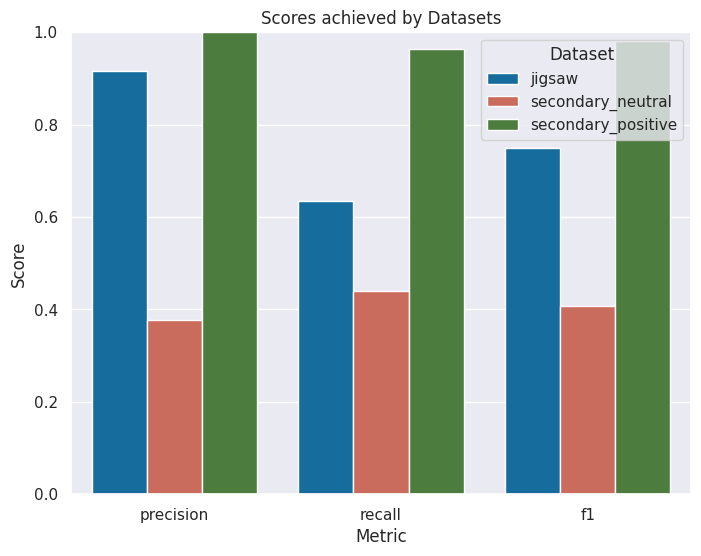

+--------------------+--------+-----------+--------+
|      Dataset       | Recall | Precision |   F1   |
+--------------------+--------+-----------+--------+
|       jigsaw       | 0.6355 |   0.9155  | 0.7502 |
| secondary_neutral  | 0.4402 |   0.3778  | 0.4066 |
| secondary_positive | 0.9643 |    1.0    | 0.9818 |
+--------------------+--------+-----------+--------+


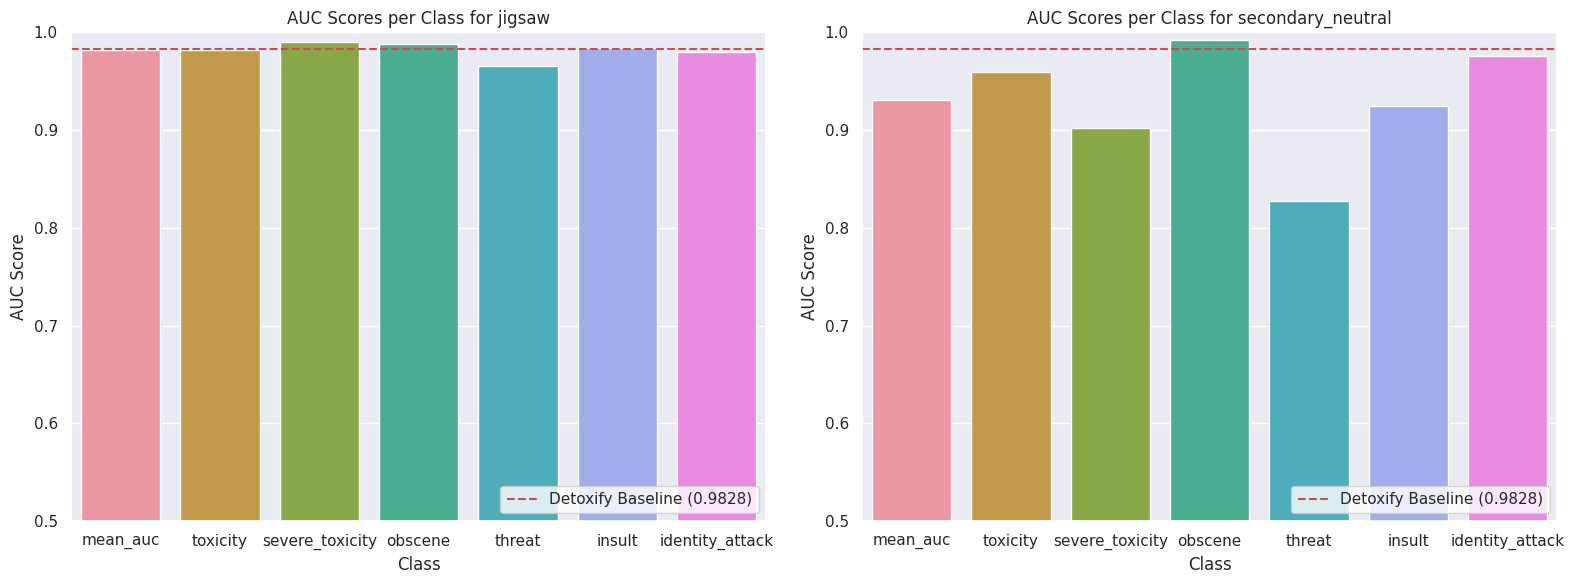

+-----------------+--------+-------------------+
|      Class      | Jigsaw | Secondary Neutral |
+-----------------+--------+-------------------+
|     mean_auc    | 0.9815 |       0.9304      |
|     toxicity    | 0.9816 |       0.9589      |
| severe_toxicity | 0.9897 |       0.9024      |
|     obscene     | 0.9884 |       0.9926      |
|      threat     | 0.9653 |       0.8274      |
|      insult     | 0.9842 |       0.9251      |
| identity_attack | 0.9795 |       0.9758      |
+-----------------+--------+-------------------+


In [11]:
json_path = '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-5-5/checkpoints/converted/epoch=0-step=3279_test_results.json'
with open(json_path, 'r') as f:
    data = json.load(f)
plot_all_data(data)

In [12]:
def compare_primary_secondary(df):
    df_melt = df.melt(id_vars=['Model'], var_name='score', value_name='value')

    sns.set(style="darkgrid")
    colors = sns.color_palette("bright", n_colors=len(df_melt['Model'].unique()))

    g = sns.catplot(x='score', y='value', hue='Model', data=df_melt, kind='bar', palette=colors,
                sharey=False, aspect=1.5, height=6, errorbar=None)
    g.set_axis_labels("", "Score")
    g.set_xticklabels(ha="right")
    g._legend.remove()

    plt.legend(title='Models', loc='center right', bbox_to_anchor=(1.2, 0.5))
    plt.xlabel('Metric')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.title("Scores achieved by Models")
    plt.show()

    # create a table of the results
    table = PrettyTable()
    table.field_names = ['Model', 'Recall', 'Precision', 'F1', 'ROC-AUC']
    for _, row in df.iterrows():
        table.add_row([row['Model'], row['Recall'], row['Precision'], row['F1'], round(row['ROC-AUC'], 4)])
    print(table)

In [13]:
json_paths = {
    "Primary": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Clean/lightning_logs/blank/checkpoints/converted/epoch=0-step=2981_test_results.json',
    "Secondary": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-5-5/checkpoints/converted/epoch=0-step=3279_test_results.json',
}
final_df = pd.DataFrame()
for model, json_path in json_paths.items():
    with open(json_path, 'r') as f:
        data = json.load(f)['secondary_neutral']
        df = pd.DataFrame.from_dict(data, orient='index').transpose()
        df = df.loc[:, ['precision', 'recall', 'f1', 'auc']]
        df['model'] = model
        final_df = pd.concat([final_df, df], ignore_index=True)
final_df = final_df.rename(columns={
    'recall': 'Recall',
    'precision': 'Precision',
    'f1': 'F1',
    'auc': "ROC-AUC",
    'model': 'Model'
})

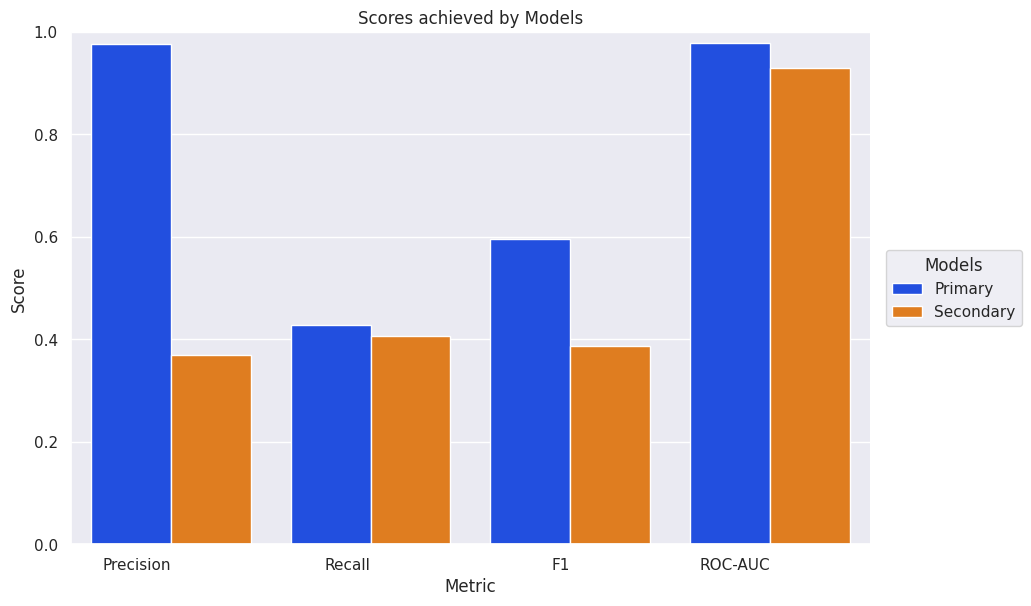

+-----------+--------+-----------+--------+---------+
|   Model   | Recall | Precision |   F1   | ROC-AUC |
+-----------+--------+-----------+--------+---------+
|  Primary  | 0.4288 |   0.9758  | 0.5958 |  0.978  |
| Secondary | 0.4058 |   0.3698  | 0.387  |  0.9304 |
+-----------+--------+-----------+--------+---------+


In [14]:
compare_primary_secondary(final_df)